## `Natural Language Processing`

In [62]:
# Import the relevant libraries
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

import string
import re
import nltk
#nltk.download("punkt")
#nltk.download("stopwords")
#nltk.download("wordnet")
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#pip install wordcloud
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from tensorflow.keras import Sequential, layers, optimizers, regularizers
from tensorflow.keras.metrics import Precision, Recall, F1Score
#!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import joblib
import pickle
from pandasql import sqldf

In [8]:
# Dependencies
"""
pip install fastapi
pip install uvicorn
pip install fastapi uvicorn 
"""

'\npip install fastapi\npip install uvicorn\npip install fastapi uvicorn \n'

In [9]:
# Load the datasets
train_df = pd.read_csv("train.csv", index_col=None)
test_df = pd.read_csv("test.csv", index_col=None)

In [10]:
# Inspect the datasets
print("Shape:", train_df.shape)
train_df.head(10)

Shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [11]:
# test_df
print("Shape:", test_df.shape)
test_df.head()

Shape: (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


- `Function for data inspection`

In [12]:
class DataCheck():
    def __init__(self, data):
        """Primary parameter of the function"""
        self.data = data

    def missing_data(self):
        self.missing = self.data.isna().sum()
        
        return {"Missing values":self.missing}
    
    def duplicated_data(self):
        self.duplicates = self.data.duplicated().sum()

        return {"Duplicated values":self.duplicates}
    
    def missing_and_duplicates(self):
    
        return self.missing_data(), self.duplicated_data()
    
# Apply the function on the data
train_check = DataCheck(train_df)
train_check.missing_and_duplicates()


({'Missing values': id             0
  keyword       61
  location    2533
  text           0
  target         0
  dtype: int64},
 {'Duplicated values': 0})

In [13]:
# Test set
test_check = DataCheck(test_df)
test_check.missing_and_duplicates()

({'Missing values': id             0
  keyword       26
  location    1105
  text           0
  dtype: int64},
 {'Duplicated values': 0})

- `Feature Selection`

The relevant columns for analysis are:
- text
- target

In [14]:
train_set = train_df.drop(columns=["id","keyword","location"], axis=1)
test_set = test_df.drop(columns=["id","keyword","location"], axis=1)

- `Since there are no duplicates or missing records in the final sets, we can analyze the data.`

Text(0.5, 1.0, 'Target class distribution')

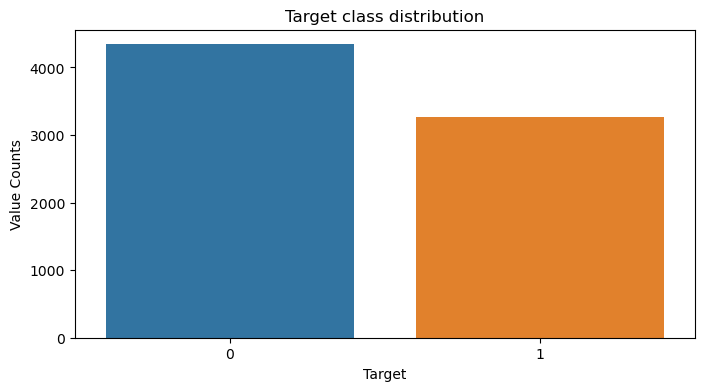

In [15]:
# Distribution of the target class
value_count = train_df.target.value_counts()
fig, ax = plt.subplots(figsize=(8,4))

sns.barplot(x=value_count.index, y=value_count.values)
ax.set_xlabel("Target")
ax.set_ylabel("Value Counts")
ax.set_title("Target class distribution")

- `There is a slight class imbalance in the target class.`

In [16]:
# Hashtags
def hash_tags(text):

    # Lower the text
    text = text.apply(lambda x: x.lower())

    # Split the text into individual words
    words = text.apply(lambda x:x.split())

    hashtags = [word for word_list in words for word in word_list if word.startswith("#")]
    
    return hashtags
hash_tags(train_set["text"])[:10]

['#earthquake',
 '#wildfires',
 '#alaska',
 '#wildfires',
 '#rockyfire',
 '#cafire',
 '#wildfires',
 '#flood',
 '#disaster',
 '#flooding']

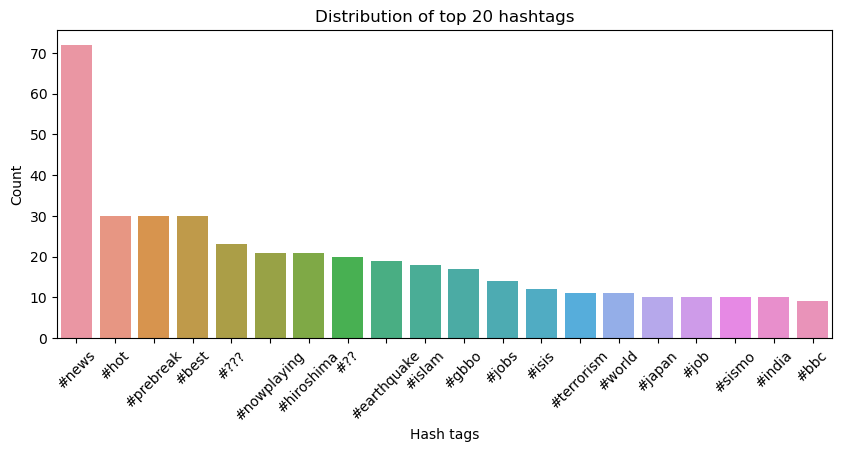

In [17]:
# Count of hash tags
count = pd.Series(hash_tags(train_set["text"])).value_counts(ascending=False)[:20]   

fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(x=count.index, y=count.values)
ax.set_xlabel("Hash tags")
ax.set_ylabel("Count")
ax.set_title("Distribution of top 20 hashtags")
ax.tick_params(axis="x", rotation=45)

<h4>1. Remove URLS</h4>

In [18]:
def clean_text(text):
    # Remove URLs
    text_no_urls = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

    # Remove other regular expressions (replace with spaces)
    text_cleaned = re.sub(r'[^a-zA-Z\s]', '', text_no_urls)

    return text_cleaned

# Apply on the data
train_set["text"] = train_set["text"].apply(clean_text)

<h4>2. Handling Punctuations</h4>

In [19]:
# Function for lowering the text
def text_lower(text):

    text = text.lower()

    exclude = string.punctuation # Punctuations to remove

    for character in exclude:
        text = text.replace(character, "")
        
    return text

# Apply the function on the data
train_set["text"] = train_set["text"].apply(text_lower)
train_set.head(10)

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in...,1
4,just got sent this photo from ruby alaska as s...,1
5,rockyfire update california hwy closed in bo...,1
6,flood disaster heavy rain causes flash floodin...,1
7,im on top of the hill and i can see a fire in ...,1
8,theres an emergency evacuation happening now i...,1
9,im afraid that the tornado is coming to our area,1


<h4>3. Tokenizing the data</h4>

In [20]:
def tokenizer(text):
    # Function for tokenizing the text
    return word_tokenize(text)

# Apply the function to the text df
train_set["tokens"] = train_set["text"].apply(tokenizer)
train_set.head(10)

,text,target,tokens
0,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place..."
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order..."
4,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala..."
5,rockyfire update california hwy closed in bo...,1,"[rockyfire, update, california, hwy, closed, i..."
6,flood disaster heavy rain causes flash floodin...,1,"[flood, disaster, heavy, rain, causes, flash, ..."
7,im on top of the hill and i can see a fire in ...,1,"[im, on, top, of, the, hill, and, i, can, see,..."
8,theres an emergency evacuation happening now i...,1,"[theres, an, emergency, evacuation, happening,..."
9,im afraid that the tornado is coming to our area,1,"[im, afraid, that, the, tornado, is, coming, t..."


<h4>4. Removing Stopwords</h4>

- `Check for stopwords`

Text(0.5, 1.0, 'Distribution of Stopwords')

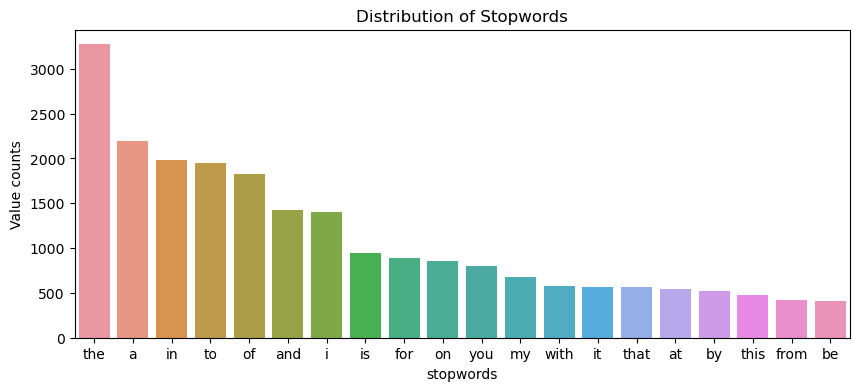

In [21]:
stop_words = stopwords.words("english") # English stopwords

# Stopwords present in the df
text_words =train_set["tokens"].explode()

# Stopwords present
text_stopwords = [word for word in text_words if word in stop_words]
counts = pd.Series(text_stopwords).value_counts(ascending=False)[:20] # Top 20 stopwords

# Visualization
fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(x=counts.index, y=counts.values)
ax.set_xlabel("stopwords")
ax.set_ylabel("Value counts")
ax.set_title("Distribution of Stopwords")

- `Remove the stopwords`

In [22]:
def stopwords_rem(text):
    stop_words = stopwords.words("english") # Stopwords to remove
    
    text = [word for word in text if word not in stop_words]
    return text

# Apply the function on the df text
train_set["tokens"] = train_set["tokens"].apply(stopwords_rem)
train_set.head(10)

,text,target,tokens
0,our deeds are the reason of this earthquake ma...,1,"[deeds, reason, earthquake, may, allah, forgiv..."
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are be...,1,"[residents, asked, shelter, place, notified, o..."
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order..."
4,just got sent this photo from ruby alaska as s...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
5,rockyfire update california hwy closed in bo...,1,"[rockyfire, update, california, hwy, closed, d..."
6,flood disaster heavy rain causes flash floodin...,1,"[flood, disaster, heavy, rain, causes, flash, ..."
7,im on top of the hill and i can see a fire in ...,1,"[im, top, hill, see, fire, woods]"
8,theres an emergency evacuation happening now i...,1,"[theres, emergency, evacuation, happening, bui..."
9,im afraid that the tornado is coming to our area,1,"[im, afraid, tornado, coming, area]"


<h4>5. Lemmatization</h4>

In [23]:
def word_lemmatizer(text):

    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word) for word in text]
    return lemmas

train_set["lemmatized"] = train_set["tokens"].apply(word_lemmatizer)
train_set.head(10)

,text,target,tokens,lemmatized
0,our deeds are the reason of this earthquake ma...,1,"[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquake, may, allah, forgive..."
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are be...,1,"[residents, asked, shelter, place, notified, o...","[resident, asked, shelter, place, notified, of..."
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfire, evacuation, order,..."
4,just got sent this photo from ruby alaska as s...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi..."
5,rockyfire update california hwy closed in bo...,1,"[rockyfire, update, california, hwy, closed, d...","[rockyfire, update, california, hwy, closed, d..."
6,flood disaster heavy rain causes flash floodin...,1,"[flood, disaster, heavy, rain, causes, flash, ...","[flood, disaster, heavy, rain, cause, flash, f..."
7,im on top of the hill and i can see a fire in ...,1,"[im, top, hill, see, fire, woods]","[im, top, hill, see, fire, wood]"
8,theres an emergency evacuation happening now i...,1,"[theres, emergency, evacuation, happening, bui...","[there, emergency, evacuation, happening, buil..."
9,im afraid that the tornado is coming to our area,1,"[im, afraid, tornado, coming, area]","[im, afraid, tornado, coming, area]"


- `Word Clouds`

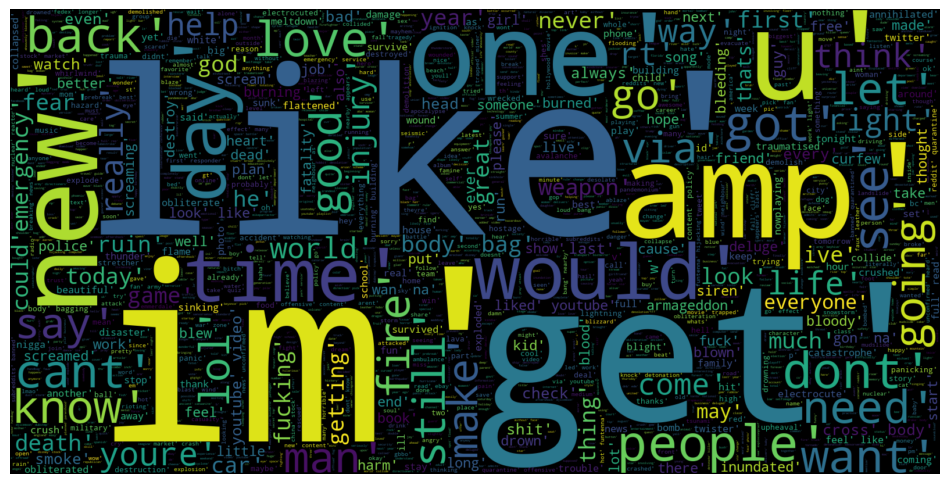

In [24]:
def generate_word_cloud(data, label):
    text = " ".join(str(text) for text in data.loc[data.target == label].lemmatized)
    wordcloud = WordCloud(background_color='black', width=1600, height=800, max_words=2000, min_font_size=5).generate(text)
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
#Wordcloud for the non-disastors -- 0
generate_word_cloud(train_set, 0)

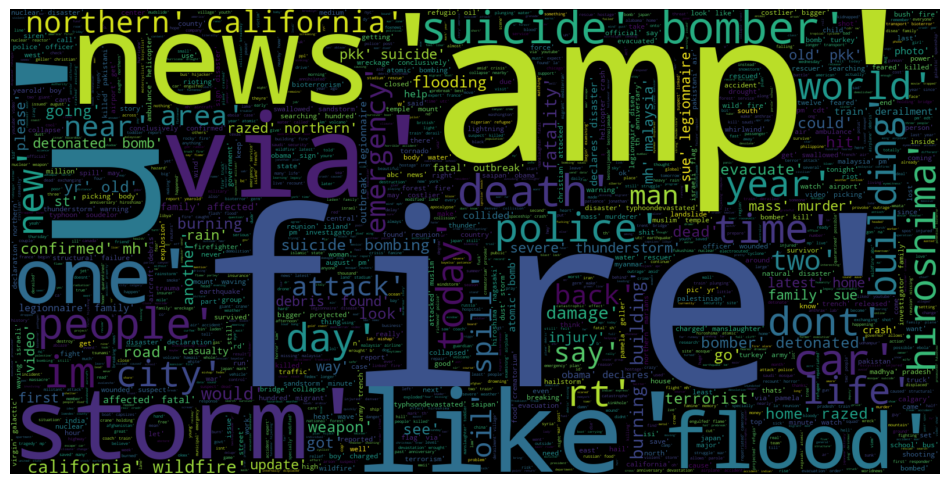

In [25]:
# Wordcloud for the disastors -- 1
generate_word_cloud(train_set, 1)

- `Convert the lemmas into strings`

In [26]:
train_set["lemmatized"] = train_set["lemmatized"].str.join(" ")
train_set.head(10)

,text,target,tokens,lemmatized
0,our deeds are the reason of this earthquake ma...,1,"[deeds, reason, earthquake, may, allah, forgiv...",deed reason earthquake may allah forgive u
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,all residents asked to shelter in place are be...,1,"[residents, asked, shelter, place, notified, o...",resident asked shelter place notified officer ...
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...",people receive wildfire evacuation order calif...
4,just got sent this photo from ruby alaska as s...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...
5,rockyfire update california hwy closed in bo...,1,"[rockyfire, update, california, hwy, closed, d...",rockyfire update california hwy closed directi...
6,flood disaster heavy rain causes flash floodin...,1,"[flood, disaster, heavy, rain, causes, flash, ...",flood disaster heavy rain cause flash flooding...
7,im on top of the hill and i can see a fire in ...,1,"[im, top, hill, see, fire, woods]",im top hill see fire wood
8,theres an emergency evacuation happening now i...,1,"[theres, emergency, evacuation, happening, bui...",there emergency evacuation happening building ...
9,im afraid that the tornado is coming to our area,1,"[im, afraid, tornado, coming, area]",im afraid tornado coming area


<h4>Data Preprocessing</h4>

- `Vectorization`

In [27]:
# Split the data into independent and dependent variables
X = train_set["lemmatized"]
y = train_set["target"]

In [28]:
tfidf_vectorizer = TfidfVectorizer()

# Fit it to the data
X_vectorized = tfidf_vectorizer.fit_transform(X)

In [29]:
# Save the vectorizer
joblib.dump(tfidf_vectorizer, "vectorizer")

['vectorizer']

<h4>Modelling</h4>

In [30]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized,
                                                    y,
                                                    test_size=0.10,
                                                    random_state=42)

- `1. Logistic Regression`

In [31]:
def classifier(X_train, X_test, y_train, y_test, classifier_):

    # Fit the model
    model = classifier_
    model.fit(X_train, y_train)

    # Predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Precision score
    print("Train Precision:", precision_score(y_train, train_preds))
    print("Test Precision:", precision_score(y_test, test_preds))

    # Recall score
    print("Train Recall:", recall_score(y_train, train_preds))
    print("Test Recall:", recall_score(y_train, train_preds))

    # f1 score
    print("Train f1_score:", f1_score(y_train, train_preds))
    print("Test f1_score:", f1_score(y_train, train_preds))

    fig ,axes = plt.subplots(ncols=2, nrows=1, figsize=(10,6))
    # Confusion matrix display
    cm = confusion_matrix(y_test, test_preds)
    display = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    display.plot(cmap="viridis", values_format="d", ax=axes[0])

    # ROC/AUC curve
    fpr, tpr, thresholds = roc_curve(y_test, test_preds)
    roc_auc = auc(fpr, tpr)

    # Plot the roc_curve
    axes[1].plot(fpr, tpr, color="darkorange", lw=2, label="ROC Curve(area = {:.2f})".format(roc_auc))
    axes[1].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title("Receiver Operating Characteristic (ROC) Curve")
    axes[1].legend(loc="lower right")


Train Precision: 0.9478010686395396
Test Precision: 0.8524590163934426
Train Recall: 0.7856899488926746
Test Recall: 0.7856899488926746
Train f1_score: 0.8591654247391952
Test f1_score: 0.8591654247391952


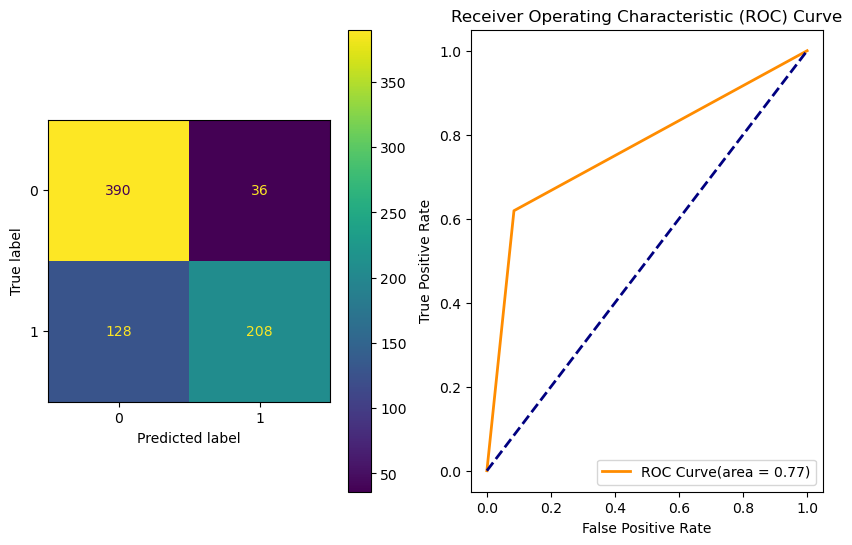

In [32]:
classifier(X_train, X_test, y_train, y_test, LogisticRegression(random_state=42))

- `The model is slightly overfitting the training data`

- `2. SVM Model`

Train Precision: 0.984994640943194
Test Precision: 0.8739130434782608
Train Recall: 0.9393526405451448
Test Recall: 0.9393526405451448
Train f1_score: 0.961632368329264
Test f1_score: 0.961632368329264


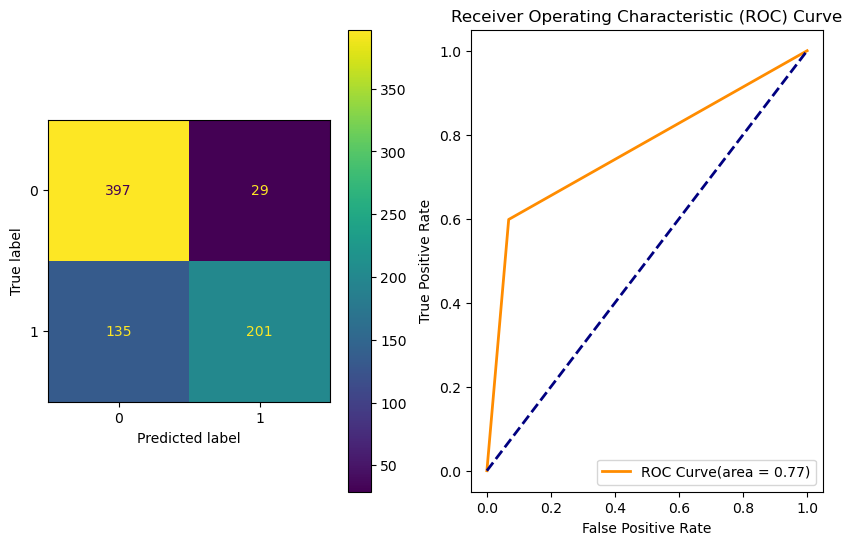

In [33]:
classifier(X_train, X_test, y_train, y_test, SVC(random_state=42))

- `This model is performing much better compared to the baseline model.`

- `3. Gradientboost model`

Train Precision: 0.9244935543278084
Test Precision: 0.8518518518518519
Train Recall: 0.5131175468483816
Test Recall: 0.5131175468483816
Train f1_score: 0.6599474145486416
Test f1_score: 0.6599474145486416


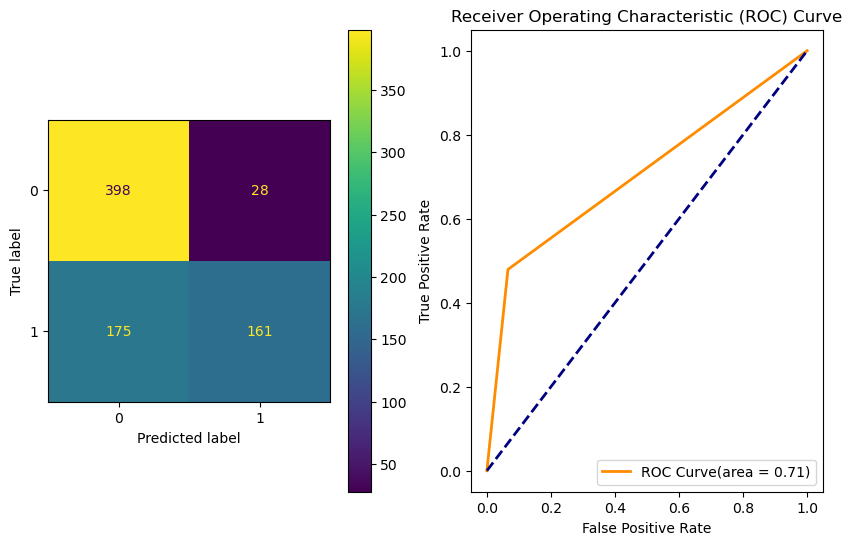

In [34]:
classifier(X_train, X_test, y_train, y_test, GradientBoostingClassifier(random_state=42))

- `4. Random Forest`

Train Precision: 0.9917098445595854
Test Precision: 0.8022813688212928
Train Recall: 0.9781942078364566
Test Recall: 0.9781942078364566
Train f1_score: 0.9849056603773585
Test f1_score: 0.9849056603773585


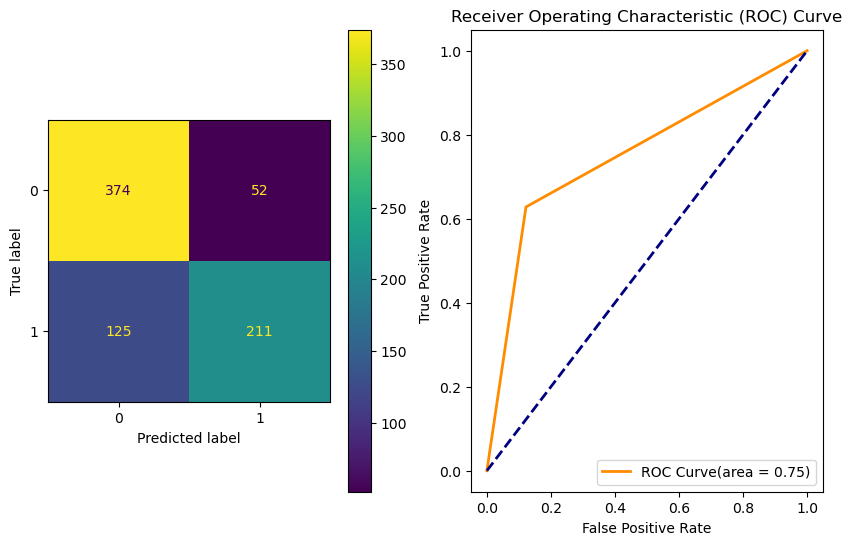

In [35]:
classifier(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42))

- `Random Forest model is performing better than the other models`

- `6. Neural Networks`

In [36]:
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

In [37]:
y_train_float = y_train.astype("float32")
y_test_float = y_test.astype("float32")

In [38]:
# Nueral net of a single hidden layer
model = Sequential()

# Input layer with 10 units
model.add(layers.Dense(10, activation="sigmoid", input_shape=(15443, )))

# Hidden layer of 20 units
model.add(layers.Dense(20, activation="sigmoid"))

# Output layer of 1 unit
model.add(layers.Dense(1, activation="sigmoid"))

# Compile
model.compile(optimizer="SGD",
              loss="binary_crossentropy",
              metrics=[Precision(), Recall(), F1Score()])

# Fit the model
results = model.fit(X_train_array,
                    y_train_float,
                    batch_size=50,
                    epochs=10,
                    validation_data=(X_test_array, y_test_float))



Epoch 1/10

138/138 [==============================] - 2s 8ms/step - loss: 0.6833 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.5998 - val_loss: 0.6871 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6120
Epoch 2/10
138/138 [==============================] - 1s 4ms/step - loss: 0.6830 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.5998 - val_loss: 0.6866 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6120
Epoch 3/10
138/138 [==============================] - 1s 4ms/step - loss: 0.6830 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.5998 - val_loss: 0.6862 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6120
Epoch 4/10
138/138 [==============================] - 1s 4ms/step - loss: 0.6831 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.5998 - val_loss: 0.6869 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6120
Epoch 5/10
138/138 [=================

- `The model is performing poorly. We will optimize it`

In [39]:
# Increasing the size of the model
model_1 = Sequential()

# Input layer with 10 units
model_1.add(layers.Dense(10, activation="sigmoid", input_shape=(15443, )))

# Hidden layer of 20 units
model_1.add(layers.Dense(20, activation="sigmoid"))

# 2nd hidden layer
model_1.add(layers.Dense(100, activation="sigmoid"))

# 3rd hidden layer
model_1.add(layers.Dense(50, activation="sigmoid"))

# Output layer of 1 unit
model_1.add(layers.Dense(1, activation="sigmoid"))

# Compile
model_1.compile(optimizer="adam", # Use "adam" optimizer
              loss="binary_crossentropy",
              metrics=[Precision(), Recall(), F1Score()])

# Fit the model
results_1 = model_1.fit(X_train_array,
                    y_train_float,
                    batch_size=70,
                    epochs=20,
                    validation_data=(X_test_array, y_test_float))

Epoch 1/20
98/98 [==============================] - 3s 10ms/step - loss: 0.7022 - precision_1: 0.4536 - recall_1: 0.1298 - f1_score: 0.5998 - val_loss: 0.6889 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.6120
Epoch 2/20
98/98 [==============================] - 1s 5ms/step - loss: 0.6838 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.5998 - val_loss: 0.6861 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.6120
Epoch 3/20
98/98 [==============================] - 1s 5ms/step - loss: 0.6825 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.5998 - val_loss: 0.6870 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.6120
Epoch 4/20
98/98 [==============================] - 1s 6ms/step - loss: 0.6826 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.5998 - val_loss: 0.6843 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.6120
Epoch 5/20
98/98 [=====

- `Regularizers`

In [40]:
# Adding a dropout
model_2 = Sequential()

# Input layer with 10 units
model_2.add(layers.Dense(10, activation="sigmoid", input_shape=(15443, )))
model_2.add(layers.Dropout(0.2)) # Dropout applied to the input layer

# Hidden layer of 20 units
model_2.add(layers.Dense(20, activation="sigmoid"))
model_2.add(layers.Dropout(0.2)) # Dropout applied to the 1st hidden layer

# 2nd hidden layer
model_2.add(layers.Dense(100, activation="sigmoid"))
model_2.add(layers.Dropout(0.2)) # 2nd layer dropout

# 3rd hidden layer
model_2.add(layers.Dense(50, activation="sigmoid"))
model_2.add(layers.Dropout(0.2)) # 3rd layer dropout

# Output layer of 1 unit
model_2.add(layers.Dense(1, activation="sigmoid"))

# Compile
model_2.compile(optimizer="adam", # Use "adam" optimizer
              loss="binary_crossentropy",
              metrics=[Precision(), Recall(), F1Score()])

# Fit the model
results_2 = model_2.fit(X_train_array,
                    y_train_float,
                    batch_size=70,
                    epochs=20,
                    validation_data=(X_test_array, y_test_float))

Epoch 1/20
98/98 [==============================] - 3s 11ms/step - loss: 0.7033 - precision_2: 0.4177 - recall_2: 0.2256 - f1_score: 0.5998 - val_loss: 0.6861 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.6120
Epoch 2/20
98/98 [==============================] - 1s 7ms/step - loss: 0.6922 - precision_2: 0.4330 - recall_2: 0.1618 - f1_score: 0.5998 - val_loss: 0.6863 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.6120
Epoch 3/20
98/98 [==============================] - 1s 10ms/step - loss: 0.6872 - precision_2: 0.4440 - recall_2: 0.1148 - f1_score: 0.5998 - val_loss: 0.6860 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.6120
Epoch 4/20
98/98 [==============================] - 1s 9ms/step - loss: 0.6855 - precision_2: 0.4251 - recall_2: 0.0726 - f1_score: 0.5998 - val_loss: 0.6877 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.6120
Epoch 5/20
98/98 [============================

- `Final Model`

The final model that is performing well is Random Forest 

In [41]:
# Final model

# Fit the model
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

# Predictions
train_preds = forest.predict(X_train)
test_preds = forest.predict(X_test)

# Precision score
print("Train Precision:", precision_score(y_train, train_preds))
print("Test Precision:", precision_score(y_test, test_preds))

# Recall score
print("Train Recall:", recall_score(y_train, train_preds))
print("Test Recall:", recall_score(y_train, train_preds))

# f1 score
print("Train f1_score:", f1_score(y_train, train_preds))
print("Test f1_score:", f1_score(y_train, train_preds))

Train Precision: 0.9917098445595854
Test Precision: 0.8022813688212928
Train Recall: 0.9781942078364566
Test Recall: 0.9781942078364566
Train f1_score: 0.9849056603773585
Test f1_score: 0.9849056603773585


In [42]:
joblib.dump(forest, "model.joblib")

['model.joblib']

In [356]:
# Save my model
with open("my_model.pkl", "wb") as f:
    pickle.dump(forest, f)

<h4>Deployment</h4>

In [2]:
# Load the saved vectorizer
vectorizer = joblib.load("vectorizer")

In [3]:
# Load the saved pickled model
with open ("my_model.pkl","rb") as f:
    model = pickle.load(f)

In [44]:
# Functions
# 1. Removing urls
def clean_text(text):
    # Remove URLs
    text_no_urls = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

    # Remove other regular expressions (replace with spaces)
    text_cleaned = re.sub(r'[^a-zA-Z\s]', '', text_no_urls)

    return text_cleaned

# 2. Handling punctuations
def text_lower(text):

    text = text.lower()

    exclude = string.punctuation # Punctuations to remove

    for character in exclude:
        text = text.replace(character, "")
        
    return text

# 3. Tokenizing
def tokenizer(text):
    # Function for tokenizing the text
    return word_tokenize(text)

# 4. Handling stopwords
def stopwords_rem(text):
    stop_words = stopwords.words("english") # Stopwords to remove
    
    text = [word for word in text if word not in stop_words]
    return text

# 5. Lemmatization
def word_lemmatizer(text):

    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word) for word in text]
    return lemmas

In [53]:
# Cloud function
def prediction(text:str):
    # Remove urls if any from the text
    text = clean_text(text)

    # Handle punctuations
    text_cleaned = text_lower(text)

    # Tokenizing
    text_tokens = tokenizer(text_cleaned)

    # Handle stopwords 
    text = stopwords_rem(text_tokens)

    # Lemmatization
    lemmas = word_lemmatizer(text)

    # Join tokens into a string
    text_final = " ".join(lemmas)

    # Text vectorization
    vectorizer_ = vectorizer
    txt_vector = vectorizer_.transform([text_final])

    # Pass the data through the model for prediction
    predictions = model.predict(txt_vector)
    prediction = int(predictions[0])
    
    # Conditions
    if prediction == 0:
        return {prediction:"Not a Disaster"}
    
    else:
        return {prediction:"Disaster"}

- `Tests`

In [54]:
# Result using random test.csv text
result = prediction("A girl who died in an airplane accident fifteen years ago")
print(result)

{1: 'Disaster'}


In [55]:
result2 = prediction("I liked a @YouTube video http://t.co/2umSxRzot3 Zombie Apocalypse: The Rescue")
print(result2)

{0: 'Not a Disaster'}


In [56]:
result3 = prediction("12.Beyonce Is my pick for http://t.co/thoYhrHkfJ Fan Army #Beyhive http://t.co/WvJ39a3BGM")
print(result3)

{0: 'Not a Disaster'}


In [57]:
result4 = prediction("#BreakingNews Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters f... http://t.co/KTKDrGVHgX #rome")
print(result4)

{0: 'Not a Disaster'}


In [59]:
result5 = prediction("Beacon Hills ~ The Glade,BLOODY HELL TEEN WOLF *O* Hayden and Liam are so cute :3 And I think Stiles's Jeep is dead huh ? Pleeease... I loved her ! @MTVteenwolf")
print(result5)

{0: 'Not a Disaster'}


In [61]:
result6 = prediction("Hiroshima marks 70 years since bomb: The Japanese city of Hiroshima marks the 70th anniversary of the dropping... http://t.co/INRGS4z0AC")
print(result6)

{1: 'Disaster'}
